### Cross Frequency Coupling

In this notebook, I will calculate the phase-amplitude coupling using Tort method. 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
import pandas as pd
import sys
sys.path.append('/home/yat-lok/workspace/tvbtools/')
from tools.signaltools import SignalToolkit
import ipywidgets as widgets
my_layout = widgets.Layout()
import typing
from typing import List
import seaborn as sns

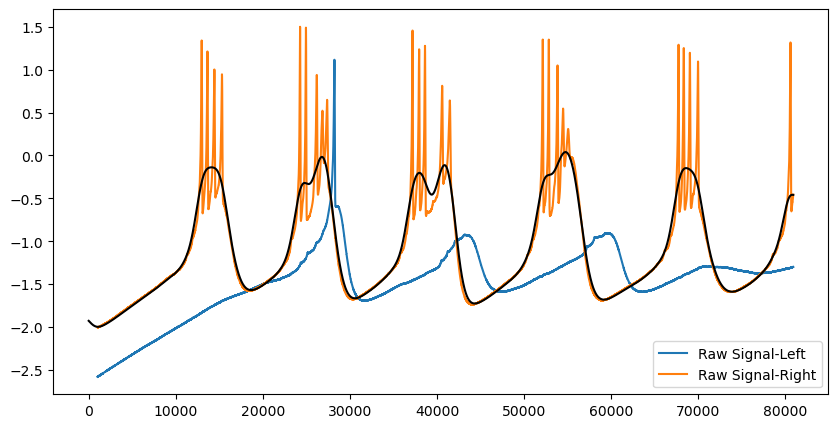

In [10]:
# read data
from cProfile import label


filename = '/home/yat-lok/workspace/data4project/lateralization/LFP_critical/SNC/4073A_0.01.csv'
df = pd.read_csv(filename)
df_left = df.iloc[1024:,5]
df_right = df.iloc[1024:,6]

df_left_low = SignalToolkit.hamming_filter(df_left, [2,8], 81920)
df_left_high = SignalToolkit.sos_filter(df_left, [20,45], 81920)
df_right_low = SignalToolkit.hamming_filter(df_right, [2,8], 81920)
df_right_high = SignalToolkit.sos_filter(df_right, [20,45], 81920)


# # visualize results
fig = plt.figure(figsize=(10,5))
axes = fig.add_subplot(111)
axes.plot(np.arange(1024, 81920-1024, 1) ,df_left[1024:], label = "Raw Signal-Left")
axes.plot(np.arange(1024, 81920-1024, 1) ,df_right[1024:], label = "Raw Signal-Right")
#axes.plot(df_left_low, c='black', label="Gamma Frequency")
axes.plot(df_right_low, c='black')
plt.legend()


/home/yat-lok/miniconda3/envs/tvbenv/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/yat-lok/miniconda3/envs/tvbenv/lib/python3.9/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


nan


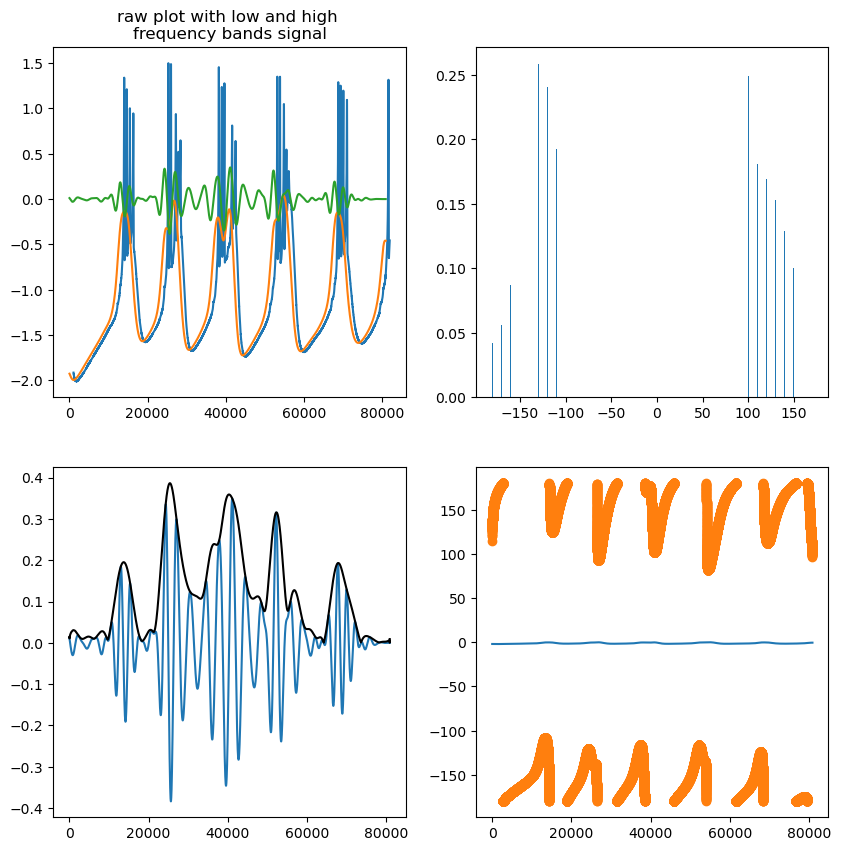

In [3]:
# %matplotlib widget
# hilbert transform
# step 1, get the amplitude envelop of high freq
akey = "df_right"
if akey == "df_left":
    key = df_left
    key_high = df_left_high
    key_low = df_left_low
else:
    key = df_right
    key_high = df_right_high
    key_low = df_right_low

h1=signal.hilbert(key_high)
amplitude_envelope = np.abs(h1)

# step 2, get the phase information of low freq
l1 = signal.hilbert(key_low)
phase_y1=np.degrees(np.angle(l1))

# step 3 bin the phase
bins = 36
cycle = 360/bins
stamp = np.arange(-180, 180, cycle)
phase_amp = np.zeros(len(stamp)) 
for ind, i in enumerate(stamp):
    phase_range = np.logical_and(phase_y1 >= i,
                                        phase_y1 < (i + cycle))
    amp_value = amplitude_envelope[phase_range]
    phase_amp[ind] = np.mean(amp_value)
# step 4, entropy method H
p_j = [p_j_single/np.sum(phase_amp) for p_j_single in phase_amp]
cap_H = -np.sum(p_j * np.log(p_j))

# step 5, calculate the MI
MI = (np.log(len(stamp))-cap_H) / np.log(len(stamp))
print(MI)

fig = plt.figure(figsize=(10,10))
axes = fig.add_subplot(222)
axes.bar(stamp, phase_amp)
# graph 2
axes2 = fig.add_subplot(221)
axes2.set_title("raw plot with low and high \nfrequency bands signal")
axes2.plot(key)
axes2.plot(key_low)
axes2.plot(key_high)

axes3 = fig.add_subplot(223)
axes3.plot(key_high)
axes3.plot(amplitude_envelope, color = "black")

axes4 = fig.add_subplot(224)
axes4.plot(key_low)
axes4.plot(phase_y1, "o")
plt.show()

0.04416085341795245
0.059275265411752556


,20.5,21.5,22.5,23.5,24.5,25.5,26.5,27.5,28.5,29.5,...,190.5,191.5,192.5,193.5,194.5,195.5,196.5,197.5,198.5,199.5
2.5,0.018116,0.019070,0.019420,0.018280,0.019127,0.019582,0.018288,0.019118,0.019961,0.018415,...,0.020074,0.020313,0.019918,0.019988,0.020310,0.019956,0.019932,0.020334,0.020049,0.019876
3.5,0.010230,0.011860,0.010582,0.010007,0.011475,0.010773,0.009960,0.011040,0.010898,0.010092,...,0.011483,0.011371,0.011288,0.011444,0.011418,0.011283,0.011399,0.011484,0.011294,0.011362
4.5,0.011992,0.013508,0.012878,0.012026,0.013262,0.013253,0.012112,0.012949,0.013502,0.012272,...,0.014051,0.014179,0.013849,0.013973,0.014214,0.013893,0.013902,0.014248,0.013965,0.013854
5.5,0.010459,0.012075,0.010597,0.010272,0.011726,0.010884,0.010225,0.011312,0.011027,0.010423,...,0.011954,0.011894,0.011754,0.011907,0.011941,0.011760,0.011854,0.011996,0.011784,0.011815
6.5,0.010495,0.011831,0.011487,0.010493,0.011571,0.011780,0.010699,0.011228,0.011984,0.010761,...,0.012151,0.012243,0.011969,0.012083,0.012278,0.012011,0.012016,0.012309,0.012069,0.011975
7.5,0.010707,0.012019,0.010983,0.010650,0.011822,0.011322,0.010714,0.011529,0.011616,0.010886,...,0.012589,0.012621,0.012377,0.012523,0.012670,0.012406,0.012456,0.012721,0.012455,0.012414
8.5,0.009585,0.011179,0.009610,0.009388,0.010846,0.009847,0.009299,0.010430,0.010033,0.009502,...,0.011161,0.011067,0.010949,0.011113,0.011123,0.010950,0.011057,0.011189,0.010966,0.011017
9.5,0.010597,0.012042,0.011458,0.010613,0.011771,0.011782,0.010789,0.011442,0.012109,0.010961,...,0.012455,0.012539,0.012268,0.012385,0.012580,0.012314,0.012318,0.012615,0.012373,0.012277
10.5,0.011118,0.012350,0.011373,0.011121,0.012210,0.011699,0.011144,0.011927,0.011934,0.011257,...,0.013034,0.013069,0.012835,0.012969,0.013117,0.012868,0.012905,0.013167,0.012917,0.012864
11.5,0.006803,0.008328,0.006610,0.006551,0.008005,0.006970,0.006645,0.007628,0.007269,0.006830,...,0.008745,0.008734,0.008486,0.008677,0.008809,0.008510,0.008597,0.008872,0.008546,0.008551


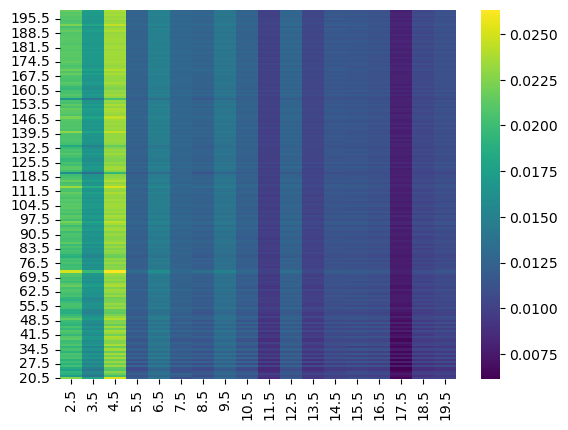

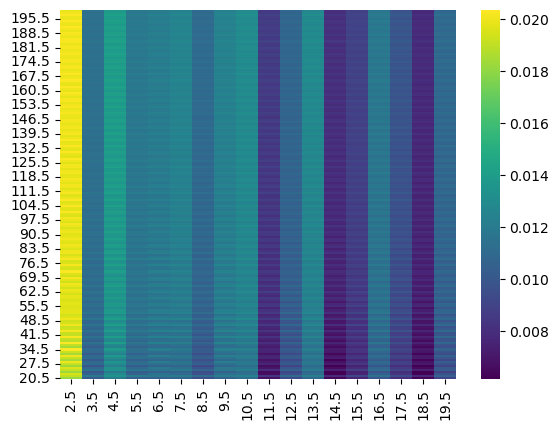

In [4]:
print(SignalToolkit.PAC(df_right, [2,8], [20,45], fs=81920))
print(SignalToolkit.PAC(df_left, [2,8], [20,45], fs=81920))
SignalToolkit.PAC_comodulogram(df_right, [2,20,1],[20, 200, 1], fs=81920)
SignalToolkit.PAC_comodulogram(df_left, [2,20,1],[20, 200, 1], fs=81920)